In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader

In [2]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 42
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
                torchvision.datasets.MNIST('./data/', train=True, download=True,
                                           transform=torchvision.transforms.Compose([
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(
                                                   (0.1307,), (0.3081,))
                                           ])),
                batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
                torchvision.datasets.MNIST('./data/', train=False, download=True,
                                           transform=torchvision.transforms.Compose([
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(
                                                   (0.1307,), (0.3081,))
                                           ])),
                batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

torch.Size([1000, 1, 28, 28])


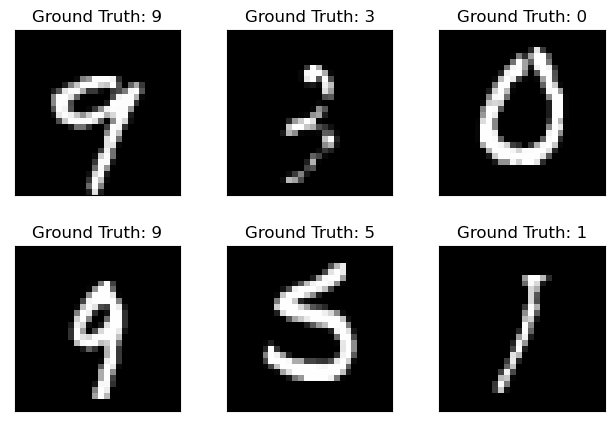

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [30]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [24]:
network = Net()
network = network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [25]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [26]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target).cuda()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

In [10]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()

            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1].cuda()
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [11]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\Suxyuuu\AppData\Local\Temp\ipykernel_5856\935008181.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.2913, Accuracy: 732/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.336169
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.301624
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.268309
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.262120
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.252974
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.224842
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.154121
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.161422
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.165789
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.099332
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.961932
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.918309
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.911964
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.912702
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.746531
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.508710
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.565160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.495764
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.347241
Train Epoch: 1 [12160/6

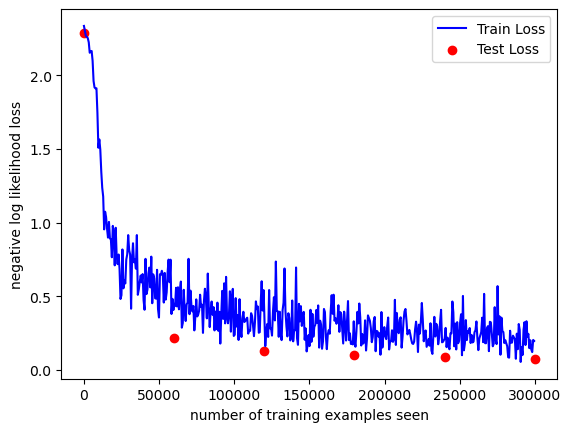

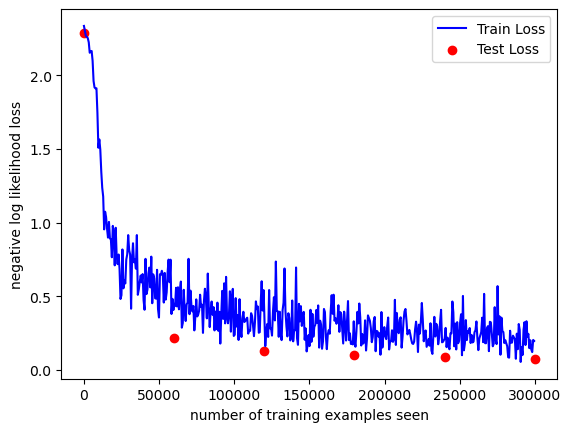

In [13]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig